<a href="https://colab.research.google.com/github/HarshaMupparaju/git_test/blob/main/Copy_of_DL_Midsem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  ***Deep learning : Midsem Submission***

Sohan Reddy A        : 2019A7PS0168G

Sudeep Kumar Nemani  : 2019A7PS0163G

Sai Harsha Mupparaju : 2019A8PS0583G


(Upload Kaggle.json before running)

In [ ]:
import warnings
warnings.filterwarnings("ignore")


import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from torchsummary import summary

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)


%matplotlib inline

In [ ]:
! pip install kaggle
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

     |████████████████████████████████| 58 kB 8.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=258b7688f97342d246ed27ae890e0ee6854d81d9207cccd8140f6a0d97cb4c83
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 98% 279M/285M [00:05<00:00, 69.1MB/s]
100% 285M/285M [00:06<00:00, 47.6MB/s]


In [ ]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
! tar -xzvf "/content/fer2013.tar.gz" 

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


# Task 1 :


## *Dataset : FER2013*

##*Preparing selected dataset*

####In the dataset, the following are given : 
*   *Training* : for training the model 
*   *PublicTest* : for validation

#### It contains 3 columns, one for image, one for its corresponing emotion, and one for usage i.e, train or test.


In [ ]:
dataset = pd.read_csv('./fer2013/fer2013.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


### The dataset contains 

* **28709** Training images
* **3589** PublicTest images
* **3589** PrivateTest images

#### We are not using PrivateTest images as we do not have access to it.

#### The Dataset is not completely balanced. The following image shows the value counts of each emotion.
#### We have a lot of data on all the other emotions except *Disgust*. This might be due to the fact that, disgust is a difficult emotion to capture.

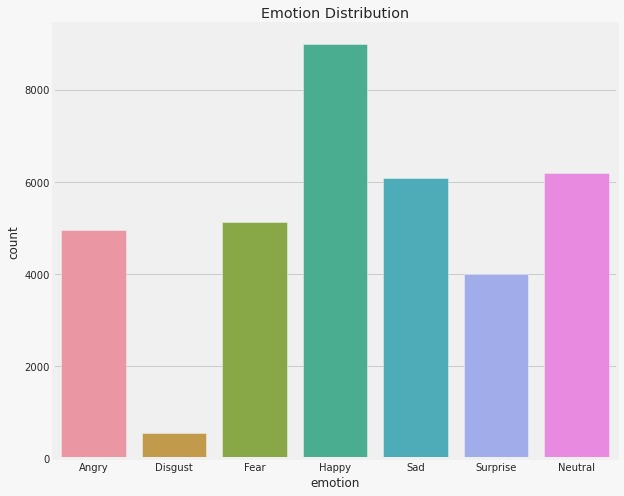

### The dataset is *relevant* to our paper in the following ways :


* The dataset has more images compared to the 2 datasets used by the paper. (*CK+ and RAF-DB*) 

* The dataset has emotions similar to what is being used by the other 2 datasets used in the paper. 



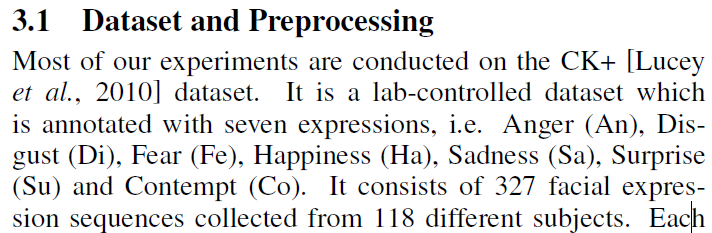
---
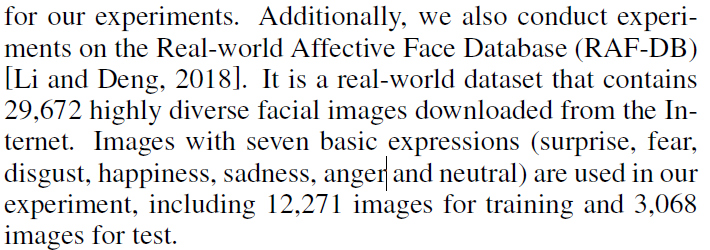

#### *Limitations*



*   As we mentioned before, there are only 600 images for *disgust* whereas the other emotions have more than 5000 each. This might cause the model to not predict disgust emotion with a higher accuracy.

##### This dataset is very popular and is widely used for facial expression recognition, thus there are not many limitations.



In [ ]:
dataset.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

In [ ]:
train_df = dataset[dataset['Usage']=='Training']
valid_df = dataset[dataset['Usage']=='PublicTest']
test_df = dataset[dataset['Usage']=='PrivateTest']
print(train_df.head())
print(valid_df.head(-1))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
       emotion                                             pixels       Usage
28709        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
28710        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
28711        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
28712        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
28713        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest
...        ...                                                ...         ...
32292        3  0 0 0 

In [ ]:
valid_df = valid_df.reset_index(drop=True) 
test_df = test_df.reset_index(drop = True)
print(test_df.head())
print('   -----   -------    -------    --------     -----    -------')
print(valid_df.head())

   emotion                                             pixels        Usage
0        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
1        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
2        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
3        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
4        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest
   -----   -------    -------    --------     -----    -------
   emotion                                             pixels       Usage
0        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
1        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
2        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
3        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
4        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest


In [ ]:
pixels = []

for pix in dataset.pixels:
    values = [int(i) for i in pix.split()]
    pixels.append(values)

pixels = np.array(pixels)

# rescaling pixel values
pixels = pixels/255.0


dataset.drop(columns=['pixels'], axis=1, inplace=True)

pix_cols = [] # for keeping track of column names

# add each pixel value as a column
for i in range(pixels.shape[1]):
    name = f'pixel_{i}'
    pix_cols.append(name)
    dataset[name] = pixels[:, i]

#### Checking how transformation works with our images

In [ ]:
def show_example(df, num):
    print('expression: ' ,df.iloc[num] )
    image = np.array([[int(i) for i in x.split()] for x in df.loc[num, ['pixels']]])
    print(image.shape)
    image = image.reshape(48,48)
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()
    return image

expression:  emotion                                                    0
pixels     179 175 176 170 149 136 129 118 105 91 87 81 7...
Usage                                               Training
Name: 107, dtype: object
(1, 2304)


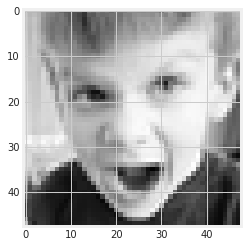

In [ ]:
i = show_example(train_df, 107)


In [ ]:
i = i.astype(np.uint8)

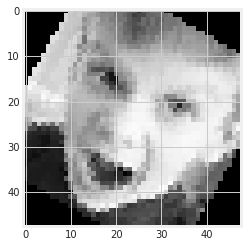

In [ ]:
transform = T.Compose([T.ToPILImage(),T.RandomHorizontalFlip(p=0.9), T.RandomRotation([-30,-30])])
tensor_img = transform(i)
plt.imshow(tensor_img, interpolation='nearest', cmap='gray')
plt.show()

### Data Preprocessing

Class to return a dataset object

In [ ]:
class FERDataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.tensor_transform = T.ToTensor()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row['emotion'])
        img = np.copy(row[pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id

Function to transform the images according to the paper.

*   Rotating the image at angles [-15, -10, -5, 0, 5, 10, 15]
*   Horizontal Flip


In [ ]:
def image_transformations(angle) -> (object, object):
    '''
        Return transformations to be applied.
        Input:
            None
        Output:
            train_tfms: transformations to be applied on the training set
            valid_tfms: transformations to be applied on the validation or test set
    '''

    train_trans = [      
        T.RandomCrop(48, padding=4, padding_mode='reflect'),     
        T.RandomRotation([angle,angle]),
        T.RandomAffine(
            degrees=0,
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        T.RandomHorizontalFlip(p=1),
        T.ToTensor(),
    ]

    val_trans = [
        T.ToTensor(), 
    ]

    train_transformations = T.Compose(train_trans)
    valid_tfms = T.Compose(val_trans)

    return train_transformations, valid_tfms

Function to get the training dataset from the whole dataset (Training and Validation)

In [ ]:
def get_train_dataset(dataframe: object,ang , transformation: bool=True) -> (object, object):
    '''
        Returns an object on FERDataset class
        Input:
            dataframe: object -> DataFrame object containing the whole data
            transformation: bool [optional] ->  Apply transformations
    '''

    # extracts rows specific to Training, PublicTest
    dataframe = dataframe.loc[dataframe.Usage.isin(['Training', 'PublicTest'])]
    # drop Usage column as it's no longer needed    
    dataframe = dataframe.drop('Usage', axis=1)

    # split dataset into training and validation set
    np.random.seed(42)  
    msk = np.random.rand(len(dataframe)) < 0.8

    train_df = dataframe[msk].reset_index()
    val_df = dataframe[~msk].reset_index()

    # get transformations
    if transformation:
        train_tfms, valid_tfms = image_transformations(ang)
    else:
        train_tfms, valid_tfms = None, None
    
    # fetch dataset
    train_ds = FERDataset(dataframe, transform=train_tfms)
    val_ds = FERDataset(dataframe, transform=valid_tfms)
    print(train_ds[0])
    return train_ds, val_ds

Function to get Dataloader from the dataset (Using angles from -15 to +15 in multiples of 5 and concatenating the datasets)

In [ ]:
def get_train_dataloader(dataframe: object, transformation=True, batch_size: int=16) -> (object, object):
    '''
        Returns train and test dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            train_dl: train dataloader object
            valid_dl: validation dataloader object
    '''
    # fetech train and validation dataset
    train_ds, valid_ds = get_train_dataset(dataframe, -15, transformation=transformation)
    for i in range(-2, 4):
      t, _ = get_train_dataset(dataframe, 5*i, transformation=transformation)
      train_ds = ConcatDataset([train_ds,t])
    print(len(train_ds))
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                     num_workers=3, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)
    
    return train_dl, valid_dl

***NOT USED NOW***

Funtion to get the Test Dataloader

In [ ]:
def get_test_dataloader(dataframe: object, batch_size: int=128) -> object:
    '''
        Returns test set dataloaders.
        Input:
            dataframe: dataset DataFrame object
            batch_size: [optional] int
        Output:
            test_dl: test dataloader object
    '''
    # extracts rows specific to PrivateTest
    test_df = dataframe.loc[dataset.Usage.isin(['PrivateTest'])]

    # drop Usage column as it's no longer needed
    test_df = test_df.drop('Usage', axis=1)

    # get transformations same as validation set
    _, valid_tfms = image_transformations()
    
    test_dataset = FERDataset(test_df, transform=valid_tfms)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=3 , pin_memory=True)

    # move loader to GPU (class defined ahead)
    test_dl = DeviceDataLoader(test_dl, device)
    return test_dl

### Testing and counting the dataset (DO NOT RUN, USES TOO MUCH RAM)

In [ ]:

train_dl, valid_dl = get_train_dataloader(dataset, batch_size=512)

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1647, 0.2000, 0.2314,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), 0)
(tensor([[[0.2314, 0.2275, 0.2706,  ..., 0.0000, 0.0000, 0.0000],
         [0.2392, 0.2157, 0.3608,  ..., 0.0000, 0.0000, 0.0000],
         [0.2078, 0.2431, 0.2706,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), 0)
(tensor([[[0.2392, 0.2235, 0.2196,  ..., 0.1373, 0.0000, 0.0000],
         [0.2118, 0.2275, 0.2157,  ..., 0.1137, 0.0000, 0.0000],
         [0.1608, 0.2000, 0.2118,  ..., 0.0941,

In [ ]:
print(len(train_dl))

NameError: ignored





```
# This is formatted as code

for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=32).permute((1, 2, 0))) # move the channel dimension
    break

_ = plt.suptitle("Transformed Images", y=0.92, fontsize=16)
```



# Task 2 :

### MODEL

Changing device to CUDA

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

Base ImageClassifation class

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {'loss': loss, 'acc': acc.detach()}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                          # Generate predictions
        loss = F.cross_entropy(out, labels)         # Calculate loss
        acc = accuracy(out, labels)                 # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = 'val_loss'
            acc_ = 'val_acc'
        else:
            loss_ = 'loss'
            acc_ = 'acc'

        batch_losses = [x[f'{loss_}'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x[f'{acc_}'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {f'{loss_}': epoch_loss.detach().item(), f'{acc_}': epoch_acc.detach().item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs} -> lr: {result['lrs'][-1]:.5f} loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}\n")

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Simple model design


In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class EmotionRecognition(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2), # output: 16 x 24 x 24

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2), # output: 64 x 12 x 12

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2), # output: 128 x 6 x 6

            nn.Flatten(), 
            nn.Linear(128*6*6, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 7))
        
    def forward(self, xb):
        return self.network(xb)

    def __repr__(self):
        return f"{self.network}"
    
    def __str__(self):
        summary(self.network, (1, 48, 48))

In [ ]:
models = {
    'EmotionRecognition': EmotionRecognition(),
}

Code to evaluate and validate the model

In [ ]:
@torch.no_grad()
def evaluate(model: object, val_loader: object) -> dict:
    '''
        Evaluate model on the validation set
        Input:
            model: training model object
            val_loder: validation data loader object
        Output:
            validation metrics
    '''

    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs=outputs, validation=True)


def get_lr(optimizer: object) -> float:
    ''' Returns current learning rate'''

    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_model(model_name: str,
              model: object, 
              epochs: int, 
              max_lr: float, 
              train_loader: object, 
              val_loader: object,
              weight_decay: float=0, 
              grad_clip: float=None, 
              opt_func: object=torch.optim.SGD):
    '''
        This function is responsible for training our model.
        We use a One Cycle learning rate policy to update our learning rate 
        with each epoch.
        The best model is saved during each epoch.
        Input:
            model_name: str 
            model: object
            epochs: int -> Max epochs
            max_lr: float -> Maximum allowed learning rate during learning
            train_loader: training set data loader
            val_loader: validation set data loader
            weight_decay: float -> value to decrease weights during training of each batch
            grad_clip: float -> maximum allowed gradient value
            opt_func: optimzer object
        Output:
            history: list of metrics
    '''

    torch.cuda.empty_cache()
    BEST_VAL_SCORE = 0.0 # for keeping track of best model score
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=max_lr,
                                                    epochs=epochs, 
                                                    steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        train_history = []
        lrs = []

        # Training Phase 
        model.train()
        for batch in tqdm(train_loader, ascii=True, desc=f'Epoch: {epoch+1}/{epochs}'):
            info = model.training_step(batch)
            loss = info['loss']
            # contains batch loss and acc for training phase
            train_history.append(info)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()


        train_result = model.get_metrics_epoch_end(train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}
        result['lrs'] = lrs
        model.epoch_end(epoch, result, epochs)

        # Save the best model
        if result['val_acc'] > BEST_VAL_SCORE:
            BEST_VAL_SCORE = result['val_acc']
            save_name = f"{model_name}_epoch-{epoch+1}_score-{round(result['val_acc'], 4)}.pth"
            !rm -f '{model_name}'_*
            torch.save(model.state_dict(), save_name)

        history.append(result)
    return history

In [ ]:
def load_best(model_name: str) -> object:
    '''Returns the best model'''

    # get model defintion
    best_model = models[model_name]

    # load trained weights
    path = r"./"
    file_path = ''
    
    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path,i)) and i.startswith(f'{model_name}'):
            file_path = os.path.join(path, i)
            
    print(f"Loaded model: {file_path[2:]} weights.")
    best_model.load_state_dict(torch.load(file_path))

    # move model to gpu
    best_model = to_device(best_model, device)
    return best_model   

#### We aren't predicting right now so we didn't use this function

# @torch.no_grad()
# def generate_prediction(model_name: str) -> None:
#     '''Generate prediction on the test set'''

#     # load test dataset
#     test_dl = get_test_dataloader(dataset)
    
#     # load model
#     model = load_best(model_name)

#     # clear cuda cache
#     torch.cuda.empty_cache()

#     # generate prediction using the validation step method defined in Base class
#     with torch.no_grad():
#         model.eval()
#         outputs = [model.validation_step(batch) for batch in test_dl]
#         metrics = model.get_metrics_epoch_end(outputs=outputs, validation=True)

#     print(f"Test Scores:\n Loss: {round(metrics['val_loss'], 3)}, Accuracy: {round(metrics['val_acc'], 3)}")

In [ ]:
def end_to_end(model_name: str, parameters: dict=None) -> dict:
    '''
        A simple function end-to-end training and testing on the selected model.
        Inputs:
            model_name: str -> chosen model name
            parameters: dict -> dictionary of hyperparameters for the model
        Outputs:
            history: dict -> dictionary containing model metrics(loss, score, lr)

    '''
    torch.cuda.empty_cache()

    # hyperparameters
    BATCH_SIZE = 512 # batch_sizes[model_name]
    epochs = parameters["epochs"]
    max_lr = parameters["max_lr"]
    weight_decay = parameters["weight_decay"]
    grad_clip = parameters["grad_clip"]
    opt_func = parameters["opt_func"]

    # get transformed dataset
    train_dl, valid_dl = get_train_dataloader(dataset, batch_size=BATCH_SIZE)
    # move dataset to use GPU
    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    # get model
    model = models[model_name]

    # move model to GPU
    model = to_device(model, device)
    
    # train model
    history = fit_model(
                model_name,
                model, 
                epochs, 
                max_lr, 
                train_dl, 
                valid_dl,
                weight_decay, 
                grad_clip, 
                opt_func
            )

    # cleaning
    torch.cuda.empty_cache()

    # generate predictions
    # print("Genearating predictions on the Test set")
    # generate_prediction(model_name)
    return history

Code to plot the graphs

In [ ]:

def plot_accuracies(history):
    train_acc = [r['acc'] for r in history]
    val_acc = [r['val_acc'] for r in history]
    plt.plot(train_acc, '-kx', label="train_acc")
    plt.plot(val_acc, '-rx', label="val_acc")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_acc)), 
                   labels=[str(i) for i in range(1, len(train_acc)+1)])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. epochs')

def plot_losses(history):
    train_losses = [r['loss'] for r in history]
    val_losses = [r['val_loss'] for r in history]
    plt.plot(train_losses, '-kx', label="train_loss")
    plt.plot(val_losses, '-rx', label="val_loss")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_losses)), 
                   labels=[str(i) for i in range(1, len(train_losses)+1)])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. epochs')

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
training_parameters = {
    "epochs": 10,
    "max_lr": 0.01,
    "weight_decay": 0.1,
    "grad_clip": 1e-4,
    "opt_func": torch.optim.Adam,
}

In [ ]:
model_name = "EmotionRecognition"
history = end_to_end(model_name, training_parameters)  #### We couldn't run the model fully in time, so we're submitting without running it

226086


Epoch: 1/3: 100%|##########| 442/442 [09:32<00:00,  1.29s/it]


Epoch: 1/3 -> lr: 0.00994 loss: 1.8937, acc: 0.2389, val_loss: 1.9454, val_acc: 0.2509



Epoch: 2/3: 100%|##########| 442/442 [09:39<00:00,  1.31s/it]


Epoch: 2/3 -> lr: 0.00463 loss: 1.9455, acc: 0.2164, val_loss: 1.9455, val_acc: 0.2509



Epoch: 3/3:   5%|4         | 21/442 [00:28<09:40,  1.38s/it]


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_accuracies(history)
plt.subplot(1, 3, 2)
plot_losses(history)

plt.subplot(1, 3, 3)
plot_lrs(history)